C:\Users\Felix\AppData\Local\Temp\ipykernel_12868\3425689996.py:19: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * E1 * E2 * (1 - cos_theta))


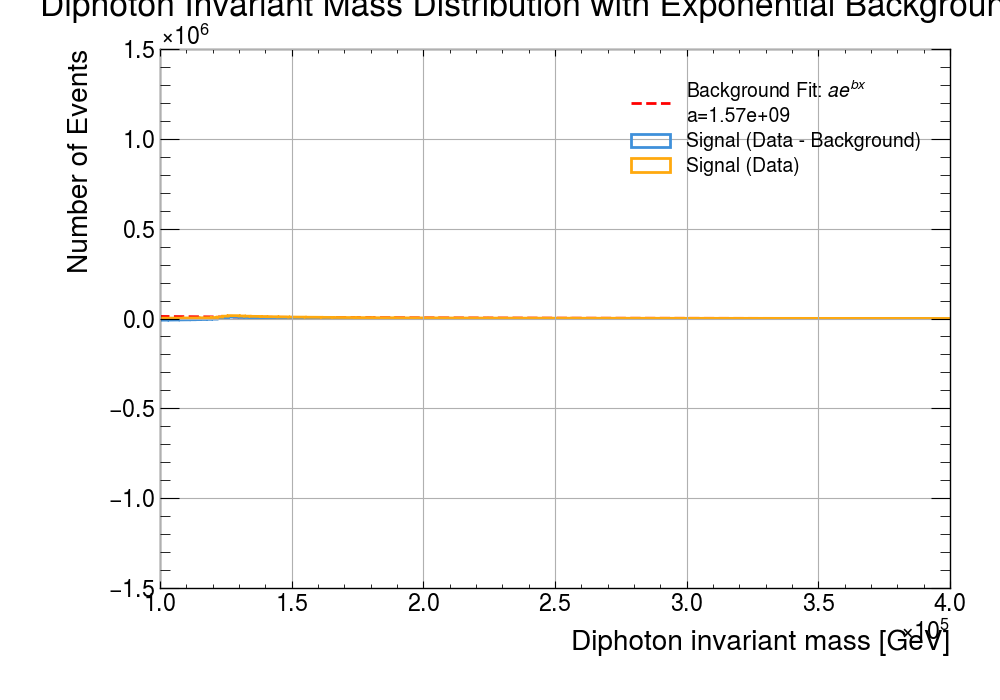

In [49]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit

# Load the ROOT file and the tree
file = uproot.open("GamGam/MC/mc_341081.ttH125_gamgam.GamGam.root")  # replace with the correct path
tree = file["mini"]

# Extract photon energy, eta, and phi
photon_E = tree["photon_E"].array(library="np")
photon_eta = tree["photon_eta"].array(library="np")
photon_phi = tree["photon_phi"].array(library="np")

# Calculate invariant mass of two highest energy photons
def invariant_mass(E1, E2, eta1, eta2, phi1, phi2):
    cos_theta = np.cos(phi1 - phi2) * np.cosh(eta1 - eta2)
    return np.sqrt(2 * E1 * E2 * (1 - cos_theta))

# Prepare an array for storing the invariant masses
masses = []

for event in range(len(photon_E)):
    sorted_indices = np.argsort(photon_E[event])[::-1]  # Sort photon energies in descending order
    if len(sorted_indices) >= 2:  # Ensure there are at least two photons
        E1, E2 = photon_E[event][sorted_indices[0]], photon_E[event][sorted_indices[1]]
        eta1, eta2 = photon_eta[event][sorted_indices[0]], photon_eta[event][sorted_indices[1]]
        phi1, phi2 = photon_phi[event][sorted_indices[0]], photon_phi[event][sorted_indices[1]]
        
        mass = invariant_mass(E1, E2, eta1, eta2, phi1, phi2)
        masses.append(mass)

# Plotting the invariant mass distribution
plt.figure(figsize=(10, 7))
hist, bins, _ = plt.hist(masses, bins=5000, histtype='step', linewidth=2, label="Data")
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define the exponential function
def exp_function(x, a, b):
    return a * np.exp(b * x)

def antipropotional(x, a, b):
    return a*(1/x) + b

# Select the background region (example: below 115 GeV)
background_region = (1.5e5 < bin_centers) & (bin_centers < 4e5)  # Adjust this range based on your data
background_x = bin_centers[background_region]
background_y = hist[background_region]

# Check for zeros or negative values
background_y = np.maximum(background_y, 1e-10)  # Replace zero or negative values to avoid log issues

# Estimate initial parameters
initial_a = 1e6
initial_b = -0.0001  # A small negative value as a reasonable guess for the decay constant

# Perform the fit with bounds
popt, pcov = curve_fit(antipropotional, background_x, background_y, p0=(initial_a, initial_b))

# Generate the fitted background curve over the entire range
#background_fit = exp_function(bin_centers, initial_a, initial_b)
background_fit = antipropotional(bin_centers, *popt)

# Subtract the background from the data
signal_hist = hist - background_fit

plt.clf()

# Plot the results
plt.plot(bin_centers, background_fit, 'r--', label=f"Background Fit: $a e^{{bx}}$\na={popt[0]:.2e}")
plt.hist(bin_centers, bins=bins, weights=signal_hist, histtype='step', linewidth=2, label="Signal (Data - Background)")
plt.hist(bin_centers, bins=bins, weights=hist, histtype='step', linewidth=2, label="Signal (Data)")
plt.xlabel("Diphoton invariant mass [GeV]")
plt.ylabel("Number of Events")
plt.title("Diphoton Invariant Mass Distribution with Exponential Background Fit")
plt.xlim(1e5, 4e5)
plt.legend()
plt.grid(True)
hep.style.use("ATLAS")  # Use ATLAS style for the plot
plt.show()


In [35]:
popt

array([ 3.9596e+04, -1.0000e-02])